In [1]:
import numpy as np
import pandas as pd
import prophet
import matplotlib.pyplot as plt
from prophet import Prophet
import altair as alt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing


df = pd.read_excel("Sample_Dataset.xlsx")

## Question


Data Scientists and Analysts are often tasked to clean and analyze datasets. We are working with an external research firm who specializes in the application of artificial intelligence to forecasting prices of financial instruments. This firm has developed a proprietary system, called “4sight”, to forecast prices of certain instruments.

To demonstrate the effectiveness of their forecasting system, the vendor has sent us attached sample dataset. The dataset includes signal values generated by the 4sight system as well as historical prices for a well-known broad market ETF.

A Portfolio Manager has asked you to:

1.       Review the quality of the data, list any potential errors, and propose corrected values. Please list each quality check error and correction applied.

2.       Please analyze the signal’s effectiveness or lack thereof in forecasting ETF price, using whatever metrics you think are most relevant.

3.       (Extra credit) Write a 1-2 paragraph summary for the Portfolio Manager addressing your observations about the efficacy and believability of the product, and recommendation for next steps.

<AxesSubplot:xlabel='Date'>

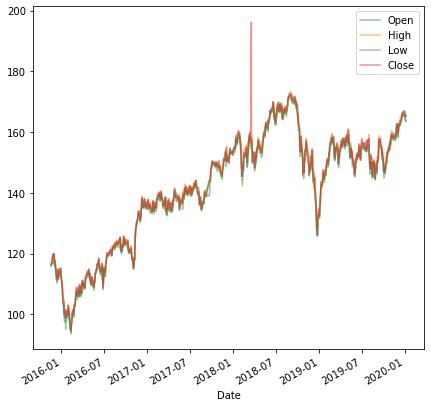

In [2]:
df.set_index('Date')[['Open',"High","Low","Close"]].plot(figsize = (7,7),alpha = 0.5)

#  1. Review the quality of the data, list any potential errors, and propose corrected values. Please list each quality check error and correction applied.

We will be using closing Price for all our valuations. Price anomalies will be replaced with the predicted price using a Machine Learning Model.

<AxesSubplot:>

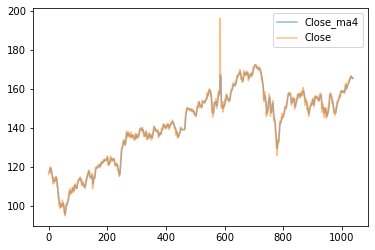

In [3]:

df['Close_ma4'] = df['Close'].rolling(window=4).mean()
df[['Close_ma4','Close']].plot(alpha = 0.5)

In [4]:
data = df[['Date','Close']]
data.columns = ['ds', 'y']


def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast
    
pred = fit_predict_model(data)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [5]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [6]:
pred[(pred["anomaly"]==1) |(pred["anomaly"]==-1)].head()

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
240,2016-11-02,127.694212,127.694212,116.992056,138.224114,115.559998,-1,0.012392
241,2016-11-03,127.787277,127.787277,117.041114,139.094928,115.000000,-1,0.017749
242,2016-11-04,127.880342,127.880342,117.006696,138.905900,115.739998,-1,0.010944
585,2018-03-19,156.805589,156.805589,144.432579,168.309155,196.279999,1,0.142505
775,2018-12-19,147.479465,147.479465,136.221219,159.671833,134.000000,-1,0.016576


In [7]:
pred[(pred["anomaly"]==1) |(pred["anomaly"]==-1)].shape

(14, 8)

In [8]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='sales'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              
plot_anomalies(pred)

alt.LayerChart(...)

In [9]:
#pip install altair vega_datasets
data_correction = pred[(pred["anomaly"]==1) |(pred["anomaly"]==-1)][['ds','fact','yhat','yhat_lower','yhat_upper']]
data_correction.columns = ['Date','Close','correction','lower_limit','upper_limit']
data_correction.to_csv("data_correction.csv")
data_correction.head()

,Date,Close,correction,lower_limit,upper_limit
240,2016-11-02,115.559998,127.694212,116.992056,138.224114
241,2016-11-03,115.000000,127.787277,117.041114,139.094928
242,2016-11-04,115.739998,127.880342,117.006696,138.905900
585,2018-03-19,196.279999,156.805589,144.432579,168.309155
775,2018-12-19,134.000000,147.479465,136.221219,159.671833


# 2. Please analyze the signal’s effectiveness or lack thereof in forecasting ETF price, using whatever metrics you think are most relevant.

Text(0, 0.5, 'Price')

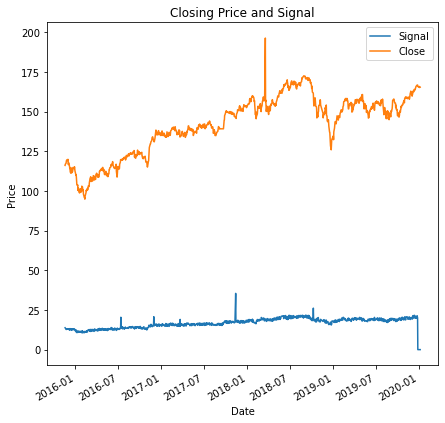

In [10]:
df = pd.read_excel("Sample_Dataset.xlsx")
df.set_index('Date',inplace = True)
df[['Signal','Close']].plot(title = "Closing Price and Signal",figsize = (7,7))
plt.ylabel('Price')

As can be seen from the chart above, there is a large difference in mean between the mean of the ETF and the mean of the Signal. Thus, from an observation, we see that the signal does not capture the bias (mean price level) of the ETF. In order to determine if the Signal captures changes in price (first, second and further derivitives of ETF price), I compare the mean normalized ETF price with the mean normalized signal.

mean_normalized_price = Price - mean(Price)

mean_normalized_signal = Signal - mean(Signal)

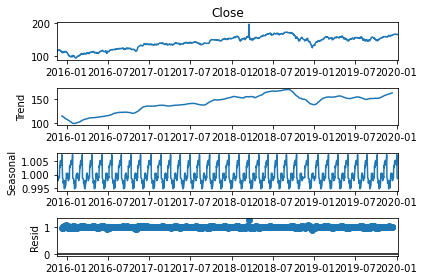

In [11]:
result = seasonal_decompose(df["Close"],model = 'multiplicative',period = 30)
result.plot()
plt.show()

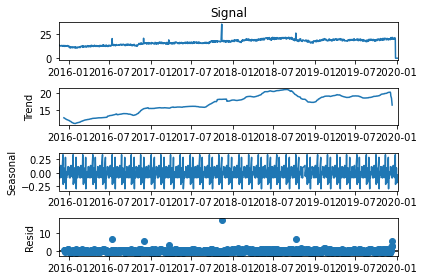

In [12]:
result = seasonal_decompose(df["Signal"],model = 'additive',period = 30)
result.plot()
plt.show()

In [13]:
df["Close_mean_normalized"] = df["Close"] - df["Close"].mean()
df["Signal_mean_normalized"] = df["Signal"] - df["Signal"].mean()


The two time series have different means compare the time series for mean and signal with mean for both = 0

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


The MAPE for the mean normalized case is 88%. Which suggest that the models are highly inaccurate. If we compare the performance of the Signal, with a flat line at Price = 0., which is the mean of the normalized closing price, we get an MAPE of 1. Thus, the signal is only 12% better than prediction using the mean price, which is the naive method

RMSE: Zero Line 18.488098021819695
MAPE: Zero Line 1.0
RMSE: Signal-Normalized 16.113204044707746
MAPE: Signal-Normalized 0.8845531093170288


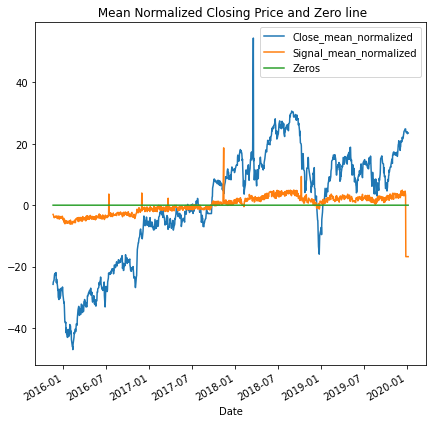

In [15]:
# report performance
df["Zeros"] = np.zeros(len(df))
mse = mean_squared_error(df["Close_mean_normalized"], df["Zeros"])
#print('MSE: '+str(mse))
mae = mean_absolute_error(df["Close_mean_normalized"], df["Zeros"])
#print('MAE: '+str(mae))


rmse_zero = np.sqrt(mean_squared_error(df["Close_mean_normalized"], df["Zeros"]))
print('RMSE: Zero Line '+str(rmse_zero))
mape_zero = np.mean(np.abs(df["Close_mean_normalized"] - df["Zeros"])/np.abs(df["Close_mean_normalized"]))
print('MAPE: Zero Line '+str(mape_zero))
df[["Close_mean_normalized","Signal_mean_normalized","Zeros"]].plot(title = " Mean Normalized Closing Price and Zero line",figsize = (7,7))


#-----------------#

#print('MAE: '+str(mae))
rmse_signal = np.sqrt(mean_squared_error(df["Close_mean_normalized"], df["Signal_mean_normalized"]))
print('RMSE: Signal-Normalized '+str(rmse_signal))
mape_signal = np.mean(np.abs(df["Close_mean_normalized"] - df["Signal_mean_normalized"])/np.abs(df["Close_mean_normalized"]))
print('MAPE: Signal-Normalized '+str(mape_signal))

## 2.1 Compare MAPE for exponential smoothing, mean model and Signal

MAPE: Exponential Smoothing 0.13297683518918785
MAPE: mean model 0.1037292477617683
MAPE: Signal 0.8789067912721177


<ipython-input-16-80a05c6fe0e3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["y_exponential_smoothning"] = y_exp
<ipython-input-16-80a05c6fe0e3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['mean'] = np.repeat(df_train["Close"].mean(),len(df_test))
<ipython-input-16-80a05c6fe0e3>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

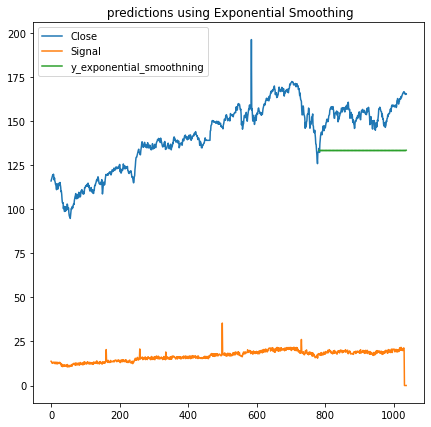

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
df.reset_index(inplace = True)
df = df[['Date','Signal','Close']]

df_test = df[df["Date"]>= pd.to_datetime('2019-01-01')]
df_train = df[df["Date"]<pd.to_datetime('2019-01-01')]

model_fit = ExponentialSmoothing(df_train['Close'], seasonal_periods=4, trend='add',
                             seasonal='mul', damped_trend=True, use_boxcox=True, 
                             initialization_method="estimated").fit()
y_exp = model_fit.forecast(len(df_test))
df_test["y_exponential_smoothning"] = y_exp
df_test['mean'] = np.repeat(df_train["Close"].mean(),len(df_test))

df_train["y_exponential_smoothning"] = np.nan

cols = ['Close','Signal','y_exponential_smoothning']
df_new = pd.concat([df_train[cols], df_test[cols]],axis =0)
df_new.plot(figsize = (7,7),title = " predictions using Exponential Smoothing")

mape1 = np.mean(np.abs(df_test["Close"] - df_test["y_exponential_smoothning"])/np.abs(df_test["Close"]))
mape2 = np.mean(np.abs(df_test["Close"] - df_test["mean"])/np.abs(df_test["Close"]))
mape3 = np.mean(np.abs(df_test["Close"] - df_test["Signal"])/np.abs(df_test["Close"]))
print('MAPE: Exponential Smoothing '+str(mape1))
print('MAPE: mean model '+str(mape2))
print('MAPE: Signal '+str(mape3))

# 3. (Extra credit) Write a 1-2 paragraph summary for the Portfolio Manager addressing your observations about the efficacy and believability of the product, and recommendation for next steps.

The Signal is only slighltly better than the Naive Prediction. Thus it will have to be discarded. There are two major errors when 
1)The average price level indicated by the Signal(16) is significantly different from the actual price (141).   2) For the mean normalized comparison of Prices between the Signal and actual Price, the Signal does a slightly better than a naive prediction (mean of the timeseries). Thus the Signal is unable to capture the Changes in Price effectively.

In 2.1 we see that the Signal (MAPE: 87%)  performs worse than the mean model (MAPE: 10%) and the exponential smoothing model (MAPE: 13%). Although, in this case, the exponential smoothing model performs worse than the mean model, through better training and using more sophisticated models, improvements over the mean model could be achieved.

I would recommend to develop basic models against which one can check performance of the Product, including models
like moving average, exponential smoothning and ARIMA. As can be seen above, a simple exponential smoothing model performs better than the custom model